## Exercise SEP Developer Test

This test is designed to assess your ability to design and develop a project from a limited set of goals, provided below. We will evaluate your project based on its fulfillment of the outlined objectives, code efficiency, readability, and adherence to best practices. Additionally, we will evaluate the structure and content of your GitHub repository according to standard practices.

1. Please perform all coding within the Google Colab environment: http://colab.research.google.com
    * Please store your project in a GitHub repository, so we can fork and run it in Colab.
        * Additionally, please create a standard GitHub repository with the expected files and directory structure.    
    * Please note that Colab doesn't automatically include additional files. To avoid potential issues, we recommend only including files that the evaluators already have access to.    
    * The evaluators will use the files SEP01.mseed, SEP02.mseed, and SEP03.mseed, which can be found in this GitHub project.
2. Import the mseed files
3. Create a database with proper normal form and constraints
4. Import the data into the newly created database
5. Create a visualization for the data. The visualization can be static but must include:    
    * A title
    * Text section displaying metadata about the miniseed data
    * Helicorder-style charts of the miniseed data (These may be built from the database data or the mseed files)
    * A map with icons indicating station locations based on the miniseed data (station lat and lon can be found on iris' API)
    * Add to the map additional stations found on IRIS' data API. Stations of interest include HOA and SUG
        * Data API information can be found at http://service.iris.edu/fdsnws/station/1/



# Prepare Google Colab environment

This notebook uses [Cartopy](https://github.com/SciTools/cartopy) for mapping, [ObsPy](https://github.com/obspy/obspy) for seismic data handling, and [mseedindex](https://github.com/EarthScope/mseedindex) for the seismic datadase.

Colab will prompt to restart the runtime following initial execution of this section. Subsequent exectutions will compleate without interuption.

In [1]:
!curl -O https://data.iana.org/time-zones/data/leap-seconds.list

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5064  100  5064    0     0  16840      0 --:--:-- --:--:-- --:--:-- 16823


In [2]:
!pip install Cartopy obspy

In [3]:
!git clone https://github.com/EarthScope/mseedindex.git
!cd mseedindex && make

import sys
sys.path.insert(0,'/content/mseedindex')
ONE_DAY_S = 60 * 60 * 24

Cloning into 'mseedindex'...
remote: Enumerating objects: 1450, done.
remote: Counting objects: 100% (476/476), done.
remote: Compressing objects: 100% (316/316), done.
remote: Total 1450 (delta 241), reused 363 (delta 150), pack-reused 974 (from 1)
Receiving objects: 100% (1450/1450), 5.85 MiB | 9.38 MiB/s, done.
Resolving deltas: 100% (806/806), done.
Configured with libcurl 7.81.0
make -C libmseed 
make[1]: Entering directory '/content/mseedindex/libmseed'
cc   -DLIBMSEED_URL -c fileutils.c -o fileutils.o
cc   -DLIBMSEED_URL -c genutils.c -o genutils.o
cc   -DLIBMSEED_URL -c msio.c -o msio.o
cc   -DLIBMSEED_URL -c lookup.c -o lookup.o
cc   -DLIBMSEED_URL -c yyjson.c -o yyjson.o
cc   -DLIBMSEED_URL -c msrutils.c -o msrutils.o
cc   -DLIBMSEED_URL -c extraheaders.c -o extraheaders.o
cc   -DLIBMSEED_URL -c pack.c -o pack.o
cc   -DLIBMSEED_URL -c packdata.c -o packdata.o
cc   -DLIBMSEED_URL -c tracelist.c -o tracelist.o
cc   -DLIBMSEED_URL -c gmtime64.c -o gmtime64.o
cc   -DLIBMSEED_URL 

# Import the mseed files

In [4]:
! git clone https://github.com/CHIGHT-USGS/SeismicData.git

fatal: destination path 'SeismicData' already exists and is not an empty directory.


# Create a database and import the data

I'm using EarthScope's mseedindex to create the database. While I have extensive experience developing and maintaining seismic database code, I believe that mseedindex is the most appropireate database for this use. It provides a use-appropriate schema and a lightweight interface.

In [5]:
from obspy.clients.filesystem.tsindex import Indexer
from obspy.clients.filesystem.tsindex import Client as TsClient

indexer = Indexer('SeismicData/SEP',
                  filename_pattern='*.mseed',
                  index_cmd='/content/mseedindex/mseedindex',
                  database='SEP.sqlite')
indexer.run()
ts_client = TsClient("SEP.sqlite")
ts_client.get_availability_extent()

[('CC',
  'SEP',
  '--',
  'EHZ',
  2023-11-11T00:00:00.000001Z,
  2023-11-26T00:00:00.000001Z)]

### Find days with sufficient data to plot on a helicorder



In [11]:
pct_min = .1
fields = ['net', 'sta', 'loc', 'chan', 'start', 'end']
md = dict(zip(fields, ts_client.get_availability_extent()[0]))
md['code'] = '.'.join([ md['net'], md['sta'], md['loc'], md['chan'] ])
days = []
date = md['start']
while date < md['end']:
  (pct, gaps) = ts_client.get_availability_percentage(network=md['net'],
                                                      station=md['sta'],
                                                      location=md['loc'],
                                                      channel=md['chan'],
                                                      starttime=date,
                                                      endtime=date + ONE_DAY_S)
  if pct > pct_min:
    days.append({
        'date': date,
        'pct': pct,
        'gaps': gaps})
  date += ONE_DAY_S

days

[{'date': 2023-11-11T00:00:00.000001Z, 'pct': 0.9960400462962963, 'gaps': 14},
 {'date': 2023-11-13T00:00:00.000001Z, 'pct': 0.9958502314699074, 'gaps': 5},
 {'date': 2023-11-25T00:00:00.000001Z, 'pct': 0.9940728009259259, 'gaps': 11}]

# Create a visualization for the data

The provided data consists of three day-length miniseed files containing data from a single-component short-period seismometer. This appears to be campaign data as there's no matching metadata in the EarthScope Metdata Aggreagator.

### Create helicorders

In [7]:
import matplotlib.pyplot as plt

for day in days:
  day['helicorder'] = f"{md['code']}_{day['date'].strftime('%Y%m%d')}.png"
  st = ts_client.get_waveforms(md['net'], md['sta'], md['loc'], md['chan'], day['date'], day['date'] + ONE_DAY_S)
  st.plot(type='dayplot',
          interval=30,
          show=False,
          size=(800,600),
          show_y_UTC_label=False,
          vertical_scaling_range=5e3,
          title=f"{md['code']} ({day['date'].strftime('%x')})",
          outfile=day['helicorder'])

md['sampling_rate'] = st[0].stats.sampling_rate

### Create map with icons indicating station locations

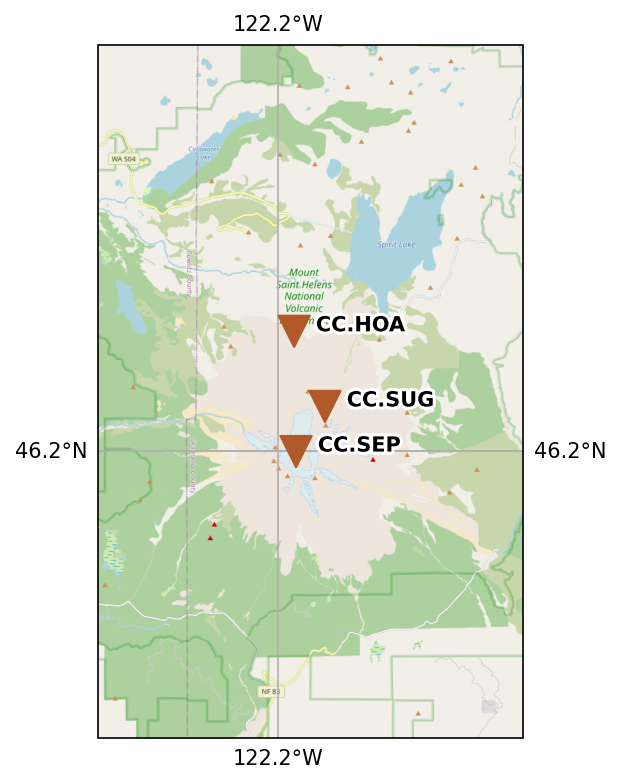

In [8]:
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles, OSM
import matplotlib.ticker as mticker
from obspy.clients.fdsn.client import Client as StationClient

lonW = -122.190857 - 0.1
lonE = -122.176262 + 0.1
latS = 46.19978 - 0.1
latN = 46.24178 + 0.1

cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2

tiler = OSM()
fig = plt.figure(figsize=(6, 6), dpi=150)
ax = fig.add_subplot(1, 1, 1, projection=tiler.crs)
ax.set_extent([lonW, lonE, latS, latN])
ax.add_image(tiler, 12)

gridlines = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
gridlines.xlocator = mticker.FixedLocator([-122, -122.2])
gridlines.ylocator = mticker.FixedLocator([46, 46.2, 46.2])

client = StationClient("IRIS")
inventory = client.get_stations(network="CC", station="SEP,HOA,SUG", level="channel",
                                starttime=st[0].stats.starttime,
                                endtime=st[-1].stats.endtime)
inventory.plot(fig=fig, show=False)
plt.savefig('map.png')
md['map'] = 'map.png'

### Produce Visualziation

SEED Code,CC.SEP.--.EHZ sps
Sampling Rate,100.0 sps
Availability,11/11/23 99.6% (14 gaps)11/13/23 99.59% (5 gaps)11/25/23 99.41% (11 gaps)

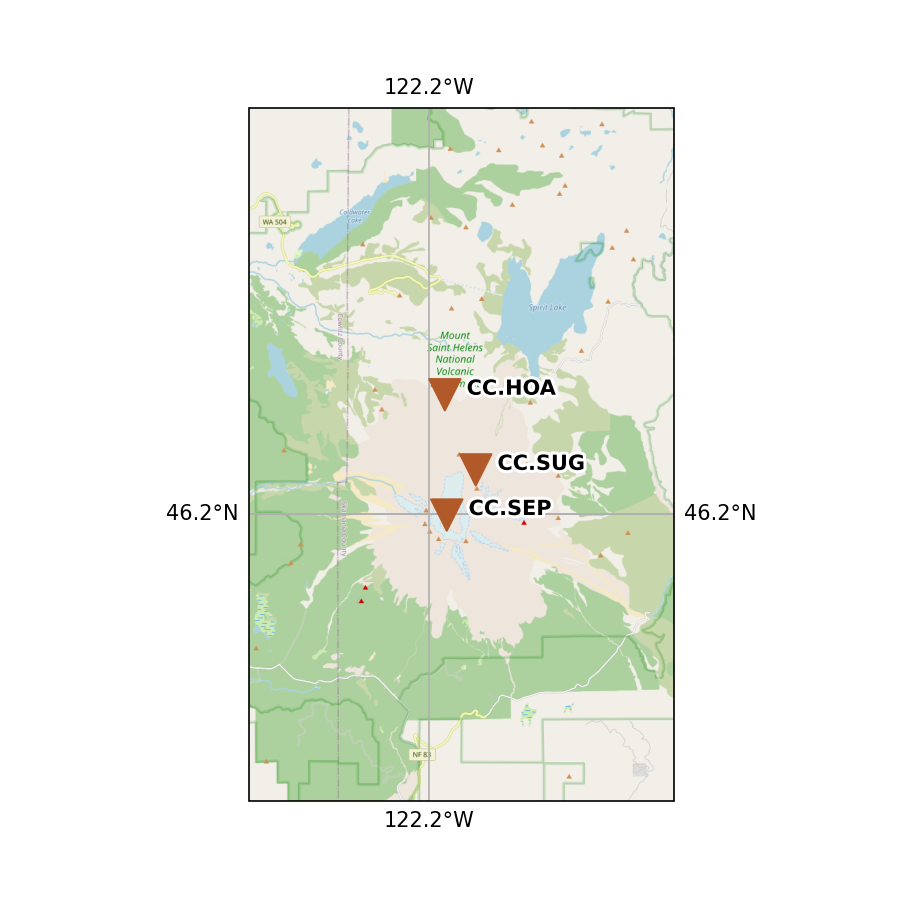
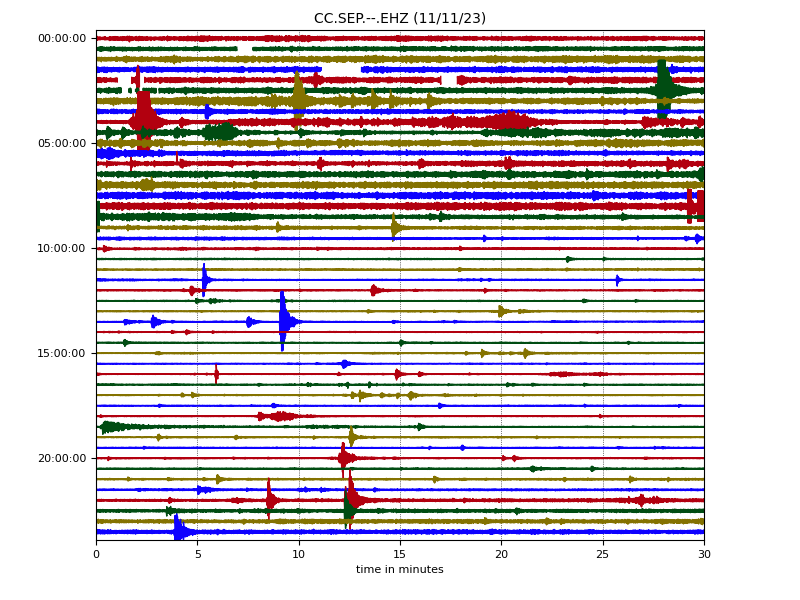
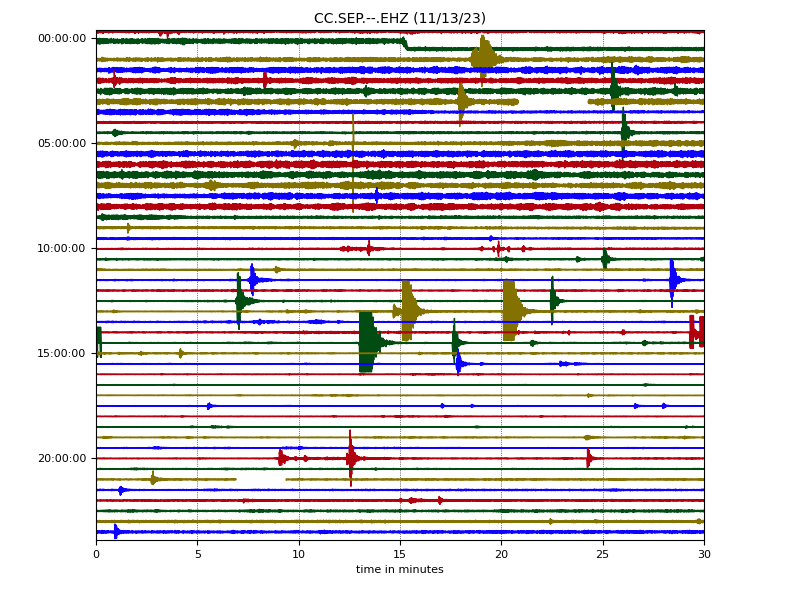
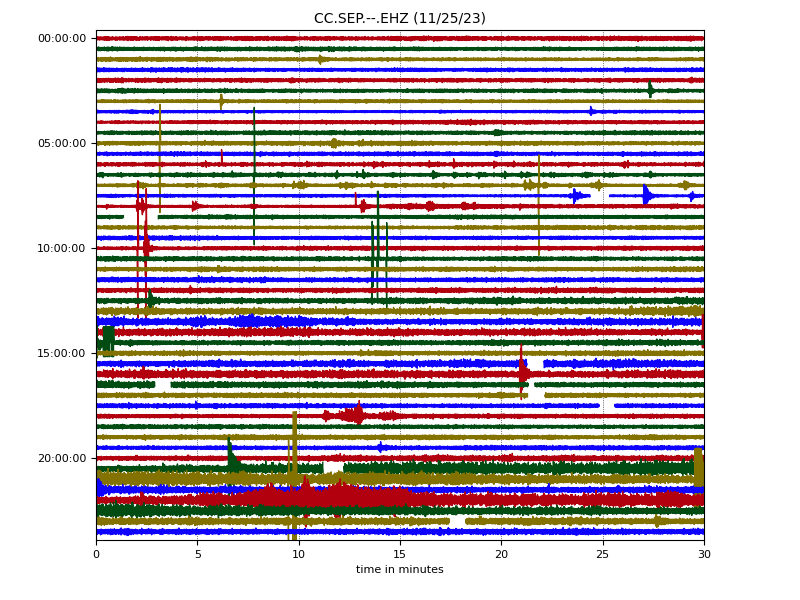

In [9]:
import IPython
import base64

availability = ""
for day in days:
  date = day['date'].strftime('%x')
  avail = round(day['pct']* 100 ,2)
  availability += f"{date} {avail}% ({day['gaps']} gaps)<br>"

with open(md['map'], 'rb') as f:
  map_img = base64.b64encode(f.read()).decode('utf-8')

html = (
    "<div style='font-size: 3rem;text-align: center; display: block;'>September lobe, Mt. St. Helens (Dome station)</div>"
    "<div style='display: flex; justify-content: space-around;'>"
    "<div style='display: flex; flex-direction: column; justify-content: center;'>"
    "<table style='text-align: left; border: 4px solid;margin: 0 auto; padding: 2rem;'>"
    f"<tr><th>SEED Code</th><td>{md['code']} sps</td></tr>"
    f"<tr><th>Sampling Rate</th><td>{md['sampling_rate']} sps</td></tr>"
    f"<tr><th>Availability</th><td>{availability}</td></tr>"
    "</table>"
    f"<img style='margin: 0 auto;' src='data:image/png;base64,{map_img}'/>"
    "</div><div style='display: flex; flex-direction: column;'>"
)

for day in days:
  with open(day['helicorder'], 'rb') as f:
    html += "<img src='data:image/png;base64," + base64.b64encode(f.read()).decode('utf-8') + "'/>"
html += "</div></div>"
IPython.display.HTML(html)